In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML, display # jupyter 사진넣기
from datetime import datetime   # system time 
import time                     # 수행시간
import json                     # json save
# from imblearn.over_sampling import SMOTE
from sklearn.tree import export_graphviz  # 결정트리 모형
# import graphviz                         # 결정트리 모형
from sklearn import tree                  # 결정트리 모형  # Classifier tree
from sklearn.inspection import permutation_importance  # feature 중요도

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, precision_recall_curve, roc_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier,
                                ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import xgboost as xgb                # python wrapper
from xgboost import XGBClassifier    # sklearn wrapper
from lightgbm import LGBMClassifier  # sklearn wrapper

import pickle                         # 모델 저장
import matplotlib as mpl              # 한글깨짐
import matplotlib.font_manager as fm  # 한글깨짐
import matplotlib.font_manager        # 한글깨짐


In [2]:
df = pd.read_csv('data/NHIS_total_model.csv')

In [3]:
df.head()

,기준년도,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),청력(좌),...,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진수검여부
0,2009,2,1,26,145.0,40.0,62.0,1.0,1.0,1.0,...,90.0,12.9,1.0,0.7,22.0,24.0,11.0,1.0,0.0,0.0
1,2009,2,1,11,145.0,40.0,67.0,1.2,1.2,1.0,...,120.0,13.5,1.0,0.5,22.0,16.0,12.0,1.0,0.0,1.0
2,2009,2,1,43,145.0,45.0,64.0,1.5,1.5,1.0,...,124.0,12.8,1.0,1.2,21.0,12.0,10.0,1.0,1.0,1.0
3,2009,2,1,41,145.0,45.0,68.0,0.2,0.1,1.0,...,115.0,12.5,1.0,0.8,15.0,9.0,13.0,1.0,1.0,0.0
4,2009,2,1,44,145.0,50.0,68.0,1.5,1.5,1.0,...,109.0,14.1,1.0,0.8,20.0,14.0,12.0,1.0,0.0,1.0


In [4]:
# print(df.info())
print(df.iloc[:, :10].head())
print(df.iloc[:, 10:].head())

   기준년도  성별코드  연령대코드(5세단위)  시도코드  신장(5Cm단위)  체중(5Kg단위)  허리둘레  시력(좌)  시력(우)  \
0  2009     2            1    26      145.0       40.0  62.0    1.0    1.0   
1  2009     2            1    11      145.0       40.0  67.0    1.2    1.2   
2  2009     2            1    43      145.0       45.0  64.0    1.5    1.5   
3  2009     2            1    41      145.0       45.0  68.0    0.2    0.1   
4  2009     2            1    44      145.0       50.0  68.0    1.5    1.5   

   청력(좌)  
0    1.0  
1    1.0  
2    1.0  
3    1.0  
4    1.0  
   청력(우)  수축기혈압  이완기혈압  식전혈당(공복혈당)  총콜레스테롤  트리글리세라이드  HDL콜레스테롤  LDL콜레스테롤  \
0    1.0  110.0   70.0        76.0   175.0      41.0      76.0      90.0   
1    1.0  113.0   61.0        78.0   187.0      59.0      55.0     120.0   
2    1.0  110.0   70.0        94.0   198.0      82.0      57.0     124.0   
3    1.0  123.0   82.0        85.0   199.0     109.0      62.0     115.0   
4    1.0  115.0   75.0        85.0   201.0      37.0      84.0     109.0   

    혈색소 

In [5]:
df.columns

Index(['기준년도', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레',
       '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
       '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
       '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부', '구강검진수검여부'],
      dtype='object')

In [12]:
# 인자로 입력받은 DataFrame을 복사 한 뒤 특정컬럼삭제(Time 컬럼) 복사된 DataFrame 반환
# 필요시 데이터 scaler 적용 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
#     df_copy['target'] = df_copy['식전혈당(공복혈당)'].apply(lambda x: 1 if x >= 126 else ( 2 if 100 <= x < 126 else 3))
    df_copy['target'] = df_copy['식전혈당(공복혈당)'].apply(lambda x: 1 if x >= 126 else 0 )
#     df_copy['target'] = pd.to_numeric(df_copy['target'])
#     df_copy.drop('식전혈당(공복혈당)', axis=1, inplace=True)
    # 
    df_copy['연령대코드(5세단위)'] = df_copy['연령대코드(5세단위)'].apply(lambda x: x*5 + 17)
    df_copy.drop(['기준년도', '시도코드'],  axis=1, inplace=True)
    df_copy.drop(['성별코드', '청력(좌)','청력(우)','요단백','구강검진수검여부' ],  axis=1, inplace=True)
    print(df_copy.head())
    return df_copy


### data split 
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
#     y_target = df_copy['target']
    y = df_copy['target']
#     X_features = df_copy.drop('target', axis=1)

    X = df_copy.drop('target', axis=1)
    scale_features = ['연령대코드(5세단위)','신장(5Cm단위)', '체중(5Kg단위)', '허리둘레',
                     '수축기혈압', '이완기혈압', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', 
                   '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피']
    #     X = np.log1p(X)
    for feature in scale_features:
        min_max_scaler = MinMaxScaler(feature_range=(1,20))
        X[feature] = min_max_scaler.fit_transform(np.array(X[feature]).reshape(-1,1))
    print(X.iloc[:, :10])
    print(X.iloc[:,10:])
    return X, y

# entropy 
def entropy(y):
    probs = []    
    for c in set(y): 
        num_same_class = sum(y == c) 
        p = num_same_class / len(y)
        probs.append(p)
    return np.sum(-p * np.log2(p) for p in probs)
        

def class_probability(feature, y):
    probs = []
    for value in set(feature): 
        # boolean mask
        select = feature == value 
        
        # y값에 해당feature boolean mask 적용
        y_new = y[select] 
        probs.append(float(len(y_new))/len(X))  
    return probs

def class_entropy(feature, y):
    ents = []
    for value in set(feature):
        select = feature == value # Split by feature value into two classes
        y_new = y[select]         # Those that exist in this class are now in y_new
        ents.append(entropy(y_new))
    return ents

def proportionate_class_entropy(feature, y):
    probs = class_probability(feature, y)
    ents = class_entropy(feature, y)
    return np.sum(np.multiply(probs, ents)) 


In [13]:
X, y = get_train_test_dataset(df)
temp_dict={}
for c in X.columns:
    new_entropy = proportionate_class_entropy(X[c], y)
    temp_dict[c] = entropy(y) - new_entropy
    print(f'{c} : {entropy(y) - new_entropy:.4f}')

   연령대코드(5세단위)  신장(5Cm단위)  체중(5Kg단위)  허리둘레  시력(좌)  시력(우)  수축기혈압  이완기혈압  \
0           22      145.0       40.0  62.0    1.0    1.0  110.0   70.0   
1           22      145.0       40.0  67.0    1.2    1.2  113.0   61.0   
2           22      145.0       45.0  64.0    1.5    1.5  110.0   70.0   
3           22      145.0       45.0  68.0    0.2    0.1  123.0   82.0   
4           22      145.0       50.0  68.0    1.5    1.5  115.0   75.0   

   식전혈당(공복혈당)  총콜레스테롤   ...    HDL콜레스테롤  LDL콜레스테롤   혈색소  혈청크레아티닌  (혈청지오티)AST  \
0        76.0   175.0   ...        76.0      90.0  12.9      0.7        22.0   
1        78.0   187.0   ...        55.0     120.0  13.5      0.5        22.0   
2        94.0   198.0   ...        57.0     124.0  12.8      1.2        21.0   
3        85.0   199.0   ...        62.0     115.0  12.5      0.8        15.0   
4        85.0   201.0   ...        84.0     109.0  14.1      0.8        20.0   

   (혈청지오티)ALT  감마지티피  흡연상태  음주여부  target  
0        24.0   11.0   1.0   0.

연령대코드(5세단위) : 0.0152
신장(5Cm단위) : 0.0009
체중(5Kg단위) : 0.0043
허리둘레 : 0.0175
시력(좌) : 0.0050
시력(우) : 0.0050
수축기혈압 : 0.0110
이완기혈압 : 0.0052
식전혈당(공복혈당) : 0.3486
총콜레스테롤 : 0.0028
트리글리세라이드 : 0.0148
HDL콜레스테롤 : 0.0058
LDL콜레스테롤 : 0.0035
혈색소 : 0.0018
혈청크레아티닌 : 0.0020
(혈청지오티)AST : 0.0060
(혈청지오티)ALT : 0.0110
감마지티피 : 0.0164
흡연상태 : 0.0018
음주여부 : 0.0000


In [26]:
result = sorted(temp_dict.items(), key=(lambda x:x[1]), reverse=True)
result

[('식전혈당(공복혈당)', 0.3486434432262726),
 ('허리둘레', 0.01748783104187207),
 ('감마지티피', 0.016438317888763154),
 ('연령대코드(5세단위)', 0.015204225520293213),
 ('트리글리세라이드', 0.014827455958344615),
 ('수축기혈압', 0.011021470677725909),
 ('(혈청지오티)ALT', 0.010986665610825841),
 ('(혈청지오티)AST', 0.005953735898102441),
 ('HDL콜레스테롤', 0.005827392757648098),
 ('이완기혈압', 0.005158885549595815),
 ('시력(좌)', 0.005009837996949207),
 ('시력(우)', 0.004976905071811422),
 ('체중(5Kg단위)', 0.004339282694872992),
 ('LDL콜레스테롤', 0.0035100783416756043),
 ('총콜레스테롤', 0.002777112958168071),
 ('혈청크레아티닌', 0.0019687964390089907),
 ('흡연상태', 0.001816904562437438),
 ('혈색소', 0.001753115504135594),
 ('신장(5Cm단위)', 0.0008914961388745146),
 ('음주여부', 3.562668056678042e-07)]

In [48]:
df_res= pd.DataFrame(result, columns=['feature', 'information_gain'])
df_res.set_index('feature', inplace=True)
df_res.head(20)

,information_gain
feature,
식전혈당(공복혈당),3.486434e-01
허리둘레,1.748783e-02
감마지티피,1.643832e-02
연령대코드(5세단위),1.520423e-02
트리글리세라이드,1.482746e-02
수축기혈압,1.102147e-02
(혈청지오티)ALT,1.098667e-02
(혈청지오티)AST,5.953736e-03
HDL콜레스테롤,5.827393e-03


In [44]:
# linux 
font_dirs = ['/home/sch/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
font_list = fm.createFontList(font_files)
fm.fontManager.ttflist.extend(font_list)
[f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name][:3]

['NanumMyeongjo Eco', 'NanumMyeongjo', 'NanumGothicCoding']

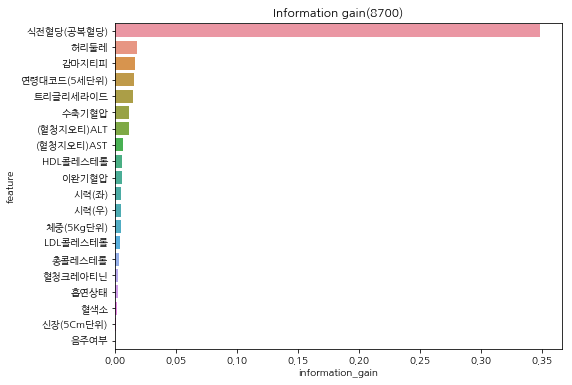

In [49]:
# 결정트리에서 feature_importances_ # gridcv에는 없음
def Plot_feature_importance(df):
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rc('axes', unicode_minus=False)
    
    plt.figure(figsize=(8,6))
    sns.barplot(x=df['information_gain'], y=df.index, orient="h")
    plt.title(f'Information gain(8700)')
    plt.savefig(f'./img/informationgain_8700.png', bbox_inches='tight') # dpi=100
#     plt.savefig('./img/model_importance.png')
#     plt.close(fig)
    plt.show()  
Plot_feature_importance(df_res)

In [ ]:
df.columns

In [ ]:
import matplotlib.pyplot as plt

colours = 'bgrcmk'  # An array of colours used during plotting later on.

# feature
def plot_entropy(probability, entropy, labels):
    """Graphical representation of entropy when splitting on each value"""

    # Some complex calculations to get the centre of the bars
    positions = np.array([0])
    positions = np.concatenate((positions, np.cumsum(probability)[:-1]))
    positions += np.divide(probability, 2)

    # Plot bars with colours
    plt.bar(positions, entropy, width=probability, color=colours[:len(probability)])

    # Set limits
    plt.ylim([0, 1])
    plt.xlim([0, 1])

    # Labels
    plt.ylabel("Entropy")
    plt.xlabel("Probability")

    # If labels are provided, plot some text
    if labels:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        for i, lab in enumerate(labels):
            # Plot text
            plt.text(positions[i], 0.1, lab, fontsize=14, verticalalignment='top', bbox=props)

# Plot 
for feature in X.columns:
    feature = X[feature]
    # Calculate probabilities and entropies
    probs = class_probability(feature, y)
    ents = class_entropy(feature, y)
    labels = set(feature)
    plot_entropy(probs, ents, labels)
    plt.show() 